## Reflection

Create a logo for a business using Reflection to ensure it meets standards.

In [1]:
GEMINI="gemini-2.0-flash-exp-image-generation"
#OPENAI="gpt-4o-mini"
CLAUDE="claude-3-7-sonnet-latest"

import os
from dotenv import load_dotenv
load_dotenv("../keys.env")
assert os.environ["GEMINI_API_KEY"][:2] == "AI",\
       "Please specify the GEMINI_API_KEY access token in keys.env file"
assert os.environ["ANTHROPIC_API_KEY"][:2] == "sk",\
       "Please specify the ANTHROPIC_API_KEY access token in keys.env file"
#assert os.environ["OPENAI_API_KEY"][:2] == "sk",\
#       "Please specify the OPENAI_API_KEY access token in keys.env file"

In [2]:
# Needed in Jupyter environment See: https://ai.pydantic.dev/troubleshooting/ 
import nest_asyncio
nest_asyncio.apply()

## Evaluate a logo image

Try out evaluation code

In [3]:
from pydantic_ai import Agent, ImageUrl, BinaryContent
from pydantic.dataclasses import dataclass
from pathlib import Path

@dataclass
class Critique:
    clarity: int
    appropriateness: int
    no_conflicts: int
    clean_design: int
    easy_to_recognize: int
    explanation: str
    
    def score(self) -> float:
        return (10 * self.clarity +
                10 * self.appropriateness + 
                30 * self.no_conflicts +
                30 * self.clean_design + 
                20 * self.easy_to_recognize) / 500.0

def evaluate_and_critique(image_url_or_filename: str, 
                          company: str,
                          company_description: str) -> Critique:
    prompt = f"""
    Analyze the following proposed logo for {company}.
    {company_description}
    
    Score the logo 1-5 on each of the following criteria:
    - It is clear from the logo what the name of the company is
    - The logo and image are appropriate for what the company does
    - The logo does not conflict with any well-known brand or competitors
    - The logo design is streamlined and clean
    - The logo stands out and is easy to recognize
    
    Explain your scores.
    """
    agent = Agent(CLAUDE,
                  result_type=Critique,
                  model_settings = {
                      "temperature": 0 # for LLM-as-Judge
                  })
    if image_url_or_filename.startswith("http"):
        result = agent.run_sync([prompt, ImageUrl(url=image_url_or_filename)])
    else:
        image_bytes  = Path(image_url_or_filename).read_bytes()
        result = agent.run_sync([prompt,
                                 BinaryContent(data=image_bytes, media_type="image/png")])
    return (result.data)

In [4]:
from IPython.display import Image as showImage
showImage(url="https://iili.io/3Hs4FMg.png", width=200) 

In [5]:
critique = evaluate_and_critique("https://iili.io/3Hs4FMg.png",
                      company="Pydantic",
                      company_description="""
                      Pydantic, the company, primarily develops and supports
                      the Pydantic library, a powerful Python data validation library.
                      They also develop and maintain PydanticAI, an AI agent framework,
                      and are working on an observability platform called Logfire. 
                      """)
print(critique.score(), critique.explanation)

0.88 Clarity (5/5): The logo clearly displays the name "Pydantic" in a bold, readable font right next to the symbol. There's no ambiguity about the company name, and the tagline "Bringing schema and sanity to your data" further reinforces what Pydantic does.

Appropriateness (4/5): The geometric pyramid/triangle symbol in pink works well for a data validation library. The shape suggests structure, validation, and organization - all relevant to Pydantic's core function. The tagline directly addresses data schema, which is central to their business. However, it doesn't visually represent their AI framework or Logfire products, focusing primarily on their main library.

No conflicts (4/5): The logo appears unique and doesn't immediately evoke any major tech brand. The pink triangle/pyramid is distinctive, though geometric shapes are common in tech logos. Without a comprehensive trademark search, it's difficult to guarantee no conflicts exist, but no obvious similarities to major competito

## Design a logo using Reflection

In [6]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
import base64

def design_logo(company, 
                company_description,
                output_filename,
                previous_logo = None,
                changes_to_make=None) -> str:
    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

    if previous_logo:
        # redo
        prompt = f"""
        Here's a proposed logo image for {company}.
        {company_description}
        
        Please edit the image and make the following changes.
        Return only the final image after all edits.
        {changes_to_make}
        """
        previous_image = Image.open(previous_logo)
        contents = [prompt, previous_image]
    else:
        # first time
        prompt = f"""
        Generate a logo image for {company} that is 600x200.
        {company_description}

        Follow modern design practices.   
        """
        contents = [prompt]

    response = client.models.generate_content(
        model=GEMINI,
        contents=contents,
        config=types.GenerateContentConfig(
          response_modalities=['TEXT', 'IMAGE']
        )
    )

    out_str = ""
    for partno, part in enumerate(response.candidates[0].content.parts):
      if part.text is not None:
        out_str = out_str + part.text
      elif part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        image.save(output_filename)
        print(f"Wrote out part#{partno} as {output_filename}")

In [7]:
company = "Hiroshi's Sushi"
company_description = f"{company} makes delicious Japanese food and our omakase is the best in the city"
image_file = "output_logo_1.png"

design_logo(company, company_description, image_file)

Wrote out part#0 as output_logo_1.png


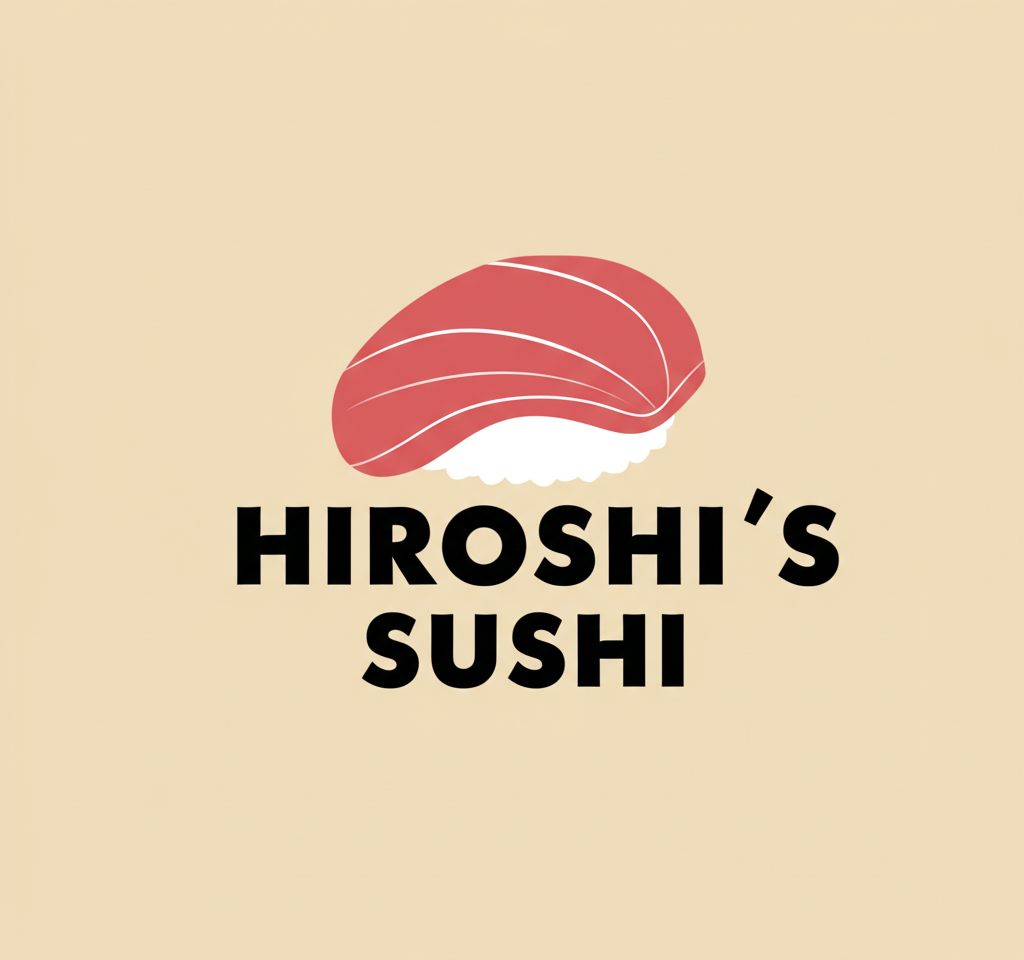

In [8]:
showImage(image_file, width=600)

In [9]:
critique = evaluate_and_critique(image_file, company, company_description)
print(critique.score(), critique.explanation)

0.9 Clarity (5/5): The logo clearly displays "HIROSHI'S SUSHI" in bold, prominent typography that is easy to read. The name is unmistakable and takes up a significant portion of the design, making the company name immediately identifiable.

Appropriateness (5/5): The logo perfectly represents a sushi restaurant with its simple yet effective illustration of a piece of nigiri sushi (specifically what appears to be tuna/maguro). The red fish on white rice is instantly recognizable as sushi, directly communicating what the business offers. The clean, minimalist approach also aligns well with Japanese aesthetic principles.

No conflicts (4/5): The design appears to be unique and doesn't immediately evoke any major sushi chain logos. The simple nigiri illustration is somewhat generic to the industry, but the overall composition with the bold typography creates a distinctive look. I'm giving it a 4 instead of 5 only because there are many sushi restaurants that use similar nigiri imagery, tho

In [10]:
def generate_extra_instructions(critique: str) -> str:
    prompt = f"""
    Use the following feedback to generate detailed extra instructions
    to send back to the designer of the logo.
    
    {critique}
    """
    agent = Agent(CLAUDE,
                  result_type=str)
    result = agent.run_sync(prompt)
    return (result.data)

In [11]:
extra_instruction = generate_extra_instructions(critique.explanation)
print(extra_instruction)

# Detailed Instructions for Logo Designer

Thank you for the excellent initial design. Based on the feedback received, your logo for Hiroshi's Sushi is already very strong, scoring highly across all evaluation criteria. To further refine this successful design, please consider the following enhancements:

## Strengths to Maintain:
- Keep the bold, prominent typography of "HIROSHI'S SUSHI" - this is working perfectly
- Preserve the clean, minimalist aesthetic that aligns with Japanese design principles
- Maintain the limited color palette (red, white, black, beige background)
- Continue with the simple nigiri (tuna/maguro) illustration as the central visual element

## Suggested Refinements:

1. **Increase Distinctiveness (Addressing the 4/5 on Uniqueness)**:
   - Consider adding a subtle, unique twist to the nigiri illustration to differentiate it from other sushi restaurants (perhaps a signature knife mark, a unique shape to the rice, or a distinctive way the fish drapes over the rice

In [12]:
def regenerate(n=3):
    for x in range(n):
        outfile = f"output_logo_2_{x+1}.png"
        design_logo(company, company_description, outfile,
                   previous_logo=image_file, changes_to_make=extra_instruction)

regenerate(3)

Wrote out part#0 as output_logo_2_1.png
Wrote out part#0 as output_logo_2_2.png
Wrote out part#0 as output_logo_2_3.png


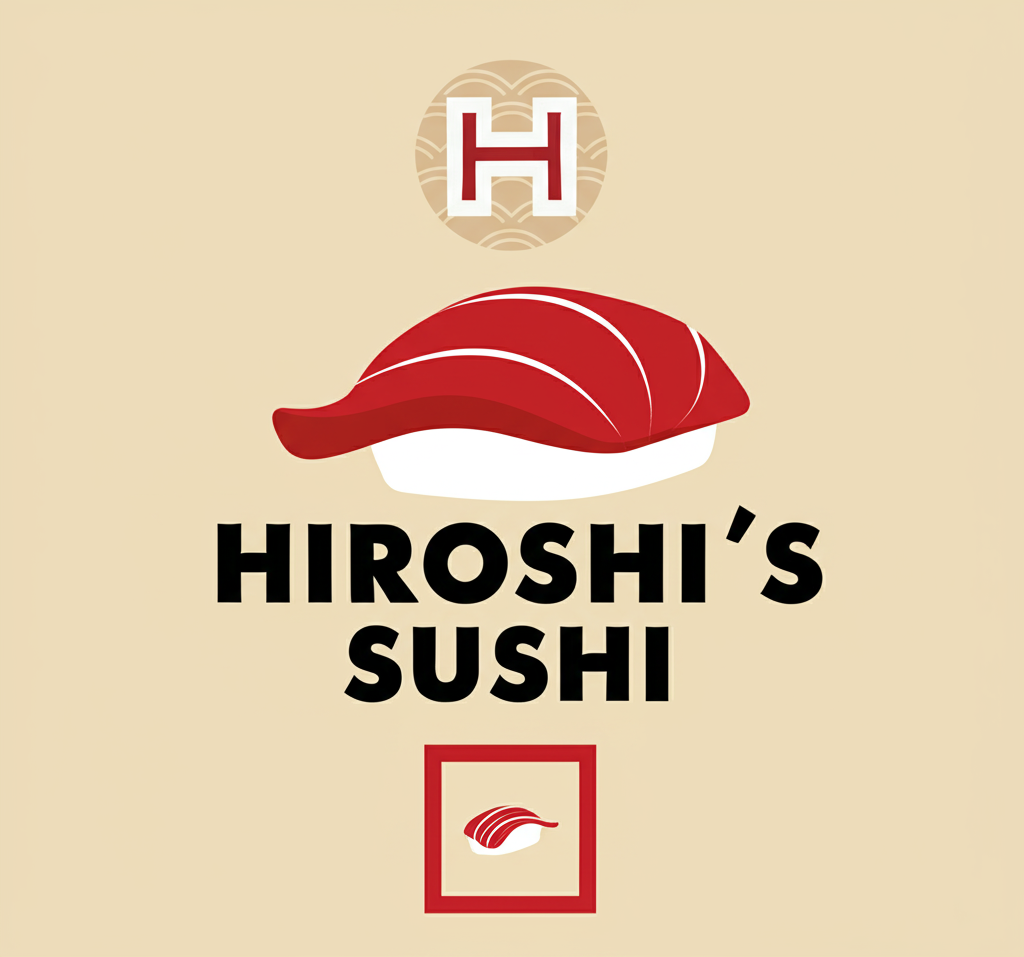

In [13]:
showImage("output_logo_2_1.png", width=600)

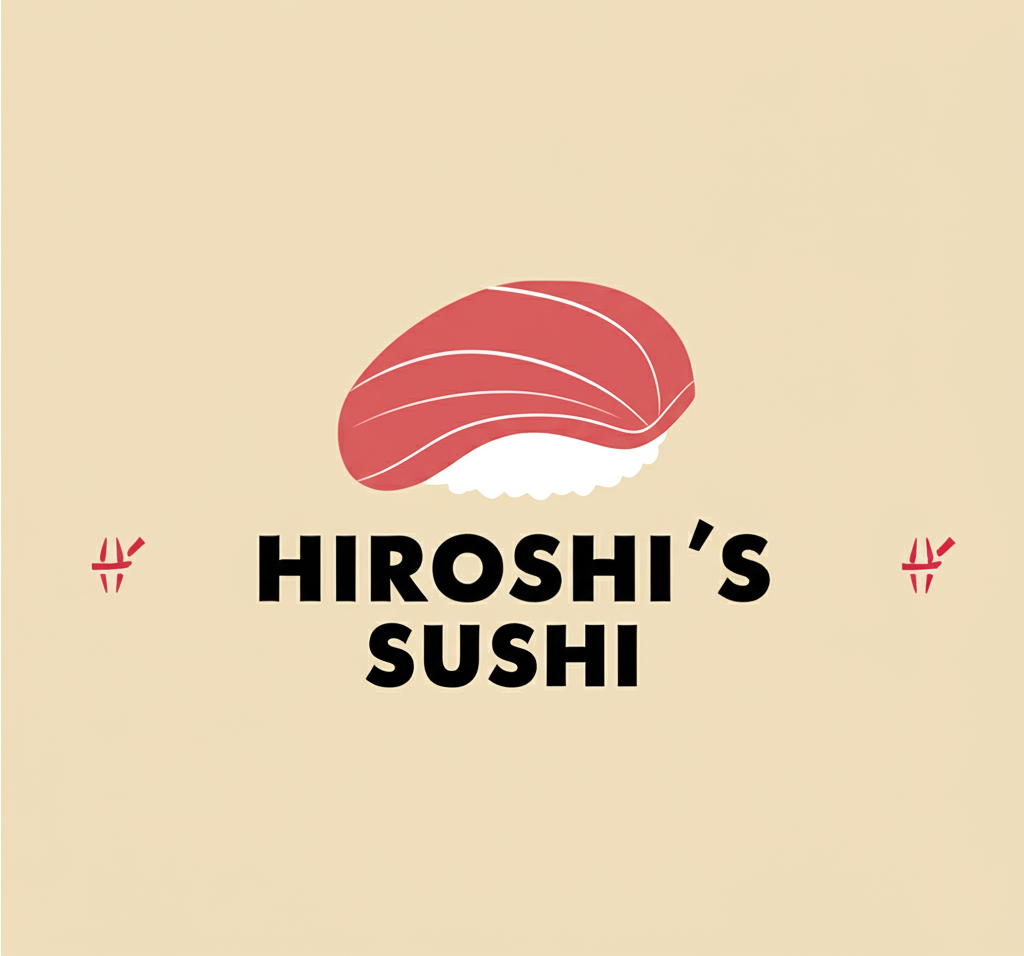

In [14]:
showImage("output_logo_2_2.png", width=600)

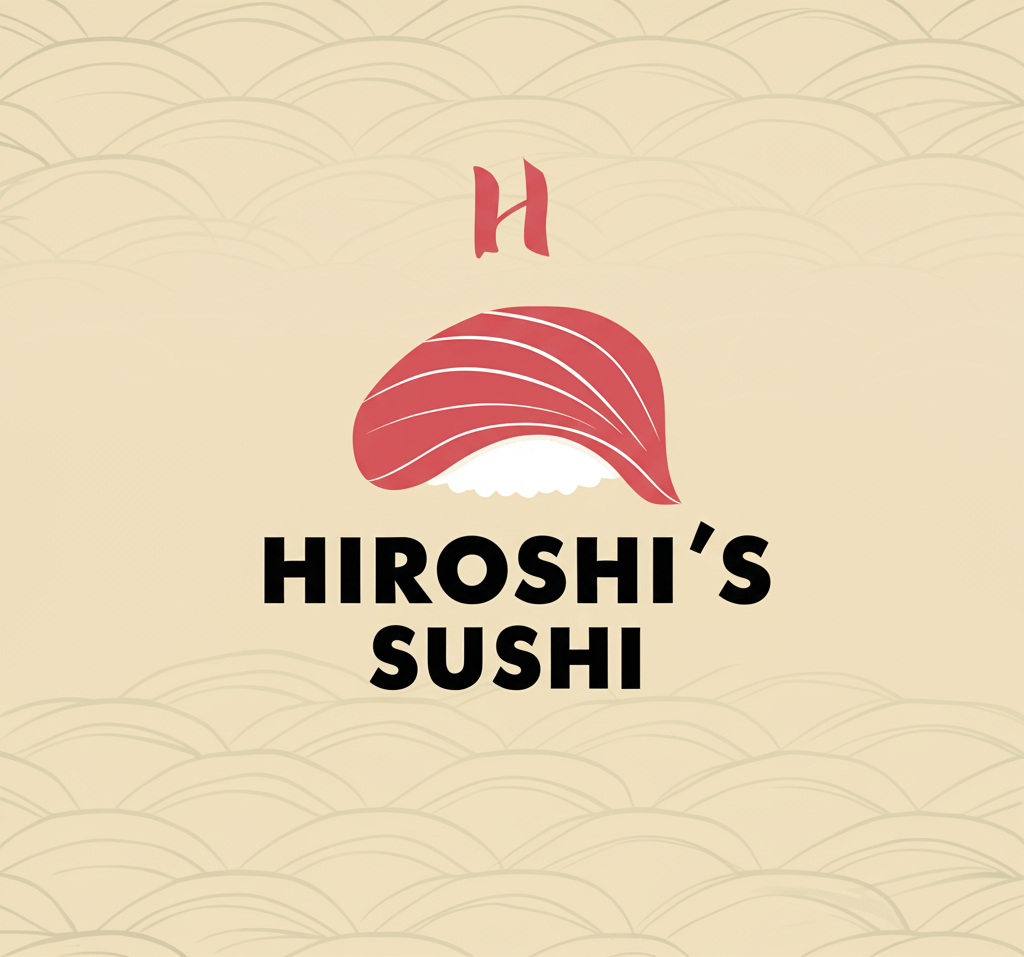

In [15]:
showImage("output_logo_2_3.png", width=600)